In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append("../")

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from stereoVO.structures import StateBolts, VO_StateMachine
from stereoVO.datasets import KittiDataset
from stereoVO.configs import yaml_parser

In [ ]:
PATH = '../../KITTI/KITTI_gray/dataset/sequences/00/'
CONFIG_PATH =  '../configs/params.yaml'

**Initialise the dataset**

In [ ]:
dataset = KittiDataset(PATH)

dataset.intrinsic = dataset.camera_intrinsic()

**Initialise the State**

In [ ]:
state_num = 0

left_frame, right_frame, ground_truth = dataset[state_num]

#initialise the state
prevState = VO_StateMachine(state_num)

#set frame state
# prevState.frames.left, prevState.frames.right = left_frame, right_frame

In [ ]:
prevState.frames = left_frame, right_frame

In [ ]:
prevState.frames.left

array([[ 94,  76,  64, ..., 255, 255, 255],
       [ 83,  70,  63, ..., 255, 255, 255],
       [ 76,  68,  65, ..., 255, 255, 255],
       ...,
       [138, 140, 140, ...,  94,  93,  94],
       [135, 131, 129, ...,  97,  97,  99],
       [131, 126, 121, ..., 102, 102, 101]], dtype=uint8)

**Load the Configs**

In [ ]:
params = yaml_parser(CONFIG_PATH)

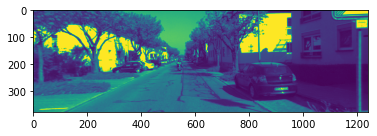

In [ ]:
plt.imshow(prevState.frames.left)

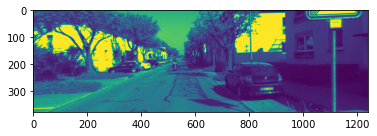

In [ ]:
plt.imshow(prevState.frames.right)

**Find Matching Keypoints**

In [ ]:
left_frame = prevState.frames.left
right_frame = prevState.frames.right

In [ ]:
if params.geometry.detection.method == "SIFT":
    detector = cv2.xfeatures2d.SIFT_create()
else:
    raise NotImplementedError("Detector has not been implemented. Please refer to the Contributing guide and raise a PR")

In [ ]:
if len(prevState.frames.left.shape)==3:
    prevState.frames.left = cv2.cvtColor(prevState.frames.left)
    
if len(prevState.frames.right.shape)==3:
    prevState.frames.right = cv2.cvtColor(prevState.frames.right)

In [ ]:
keyPointsLeft, descriptorsLeft = detector.detectAndCompute(left_frame, None)
keyPointsRight, descriptorsRight = detector.detectAndCompute(right_frame, None)

In [ ]:
#debugging code here

In [ ]:
len(keyPointsLeft), len(keyPointsRight)

(3206, 3129)

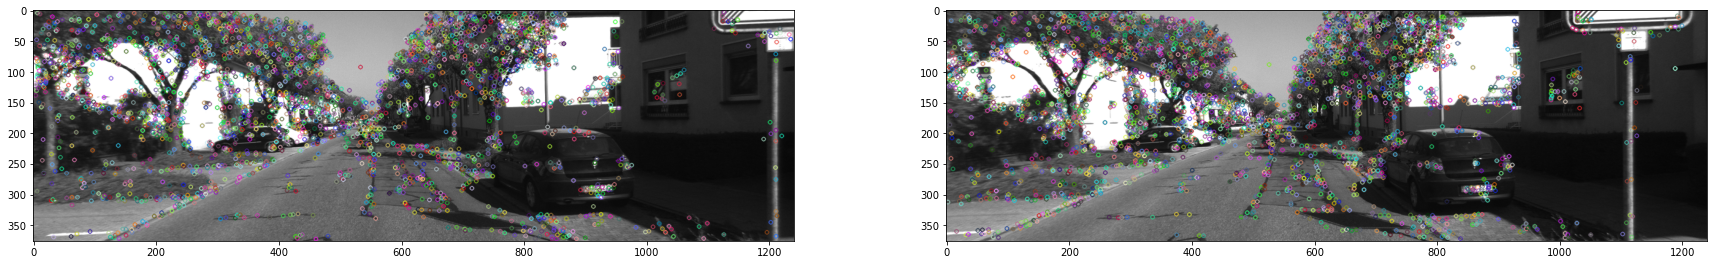

In [ ]:
if params.debug.plotting.features:
    kp_on_left_frame = cv2.drawKeypoints(left_frame, keyPointsLeft, None)
    kp_on_right_frame = cv2.drawKeypoints(right_frame, keyPointsRight, None)
    
    fig = plt.figure(figsize=(30,15))
    
    plt.subplot(1,2,1)
    plt.imshow(kp_on_left_frame)
    
    plt.subplot(1,2,2)
    plt.imshow(kp_on_right_frame)
    
    plt.show()

In [ ]:
params = yaml_parser(CONFIG_PATH)
args_feature_matcher = params.geometry.featureMatcher.configs

In [ ]:
indexParams = args_feature_matcher.indexParams
searchParams = args_feature_matcher.searchParams

if params.geometry.featureMatcher.method == "FlannMatcher":
    matcher = cv2.FlannBasedMatcher(indexParams, searchParams)

In [ ]:
matches = matcher.knnMatch(descriptorsLeft, descriptorsRight, args_feature_matcher.K);

In [ ]:
#Apply ratio test 
goodMatches = [] 
ptsLeft = [] 
ptsRight = [] 

for m, n in matches:  
    if m.distance < args_feature_matcher.maxRatio * n.distance: 
        goodMatches.append([m]) 
        ptsLeft.append(keyPointsLeft[m.queryIdx].pt) 
        ptsRight.append(keyPointsRight[m.trainIdx].pt)
        
ptsLeft = np.array(ptsLeft).astype('float64')
ptsRight = np.array(ptsRight).astype('float64')

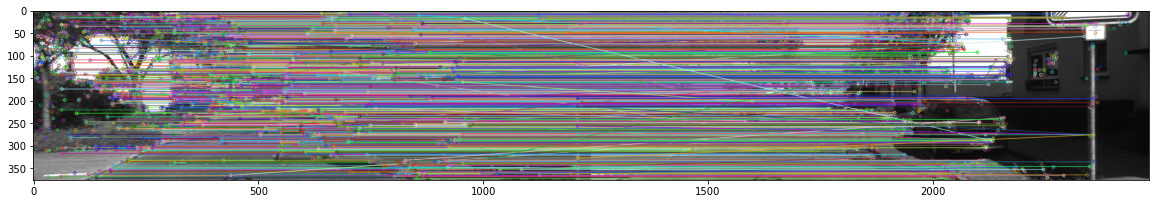

In [ ]:
if params.debug.plotting.featureMatches:
    feature_matches = cv2.drawMatchesKnn(prevState.frames.left, keyPointsLeft, 
                                      prevState.frames.right, keyPointsRight, 
                                      goodMatches, outImg = None, flags=0)
    plt.figure(figsize=(20,10))
    plt.imshow(feature_matches)
    plt.show()    

In [ ]:
prevState.matchedPoints.left = ptsLeft
prevState.matchedPoints.right = ptsRight
prevState.keypoints.left = keyPointsLeft
prevState.keypoints.right = keyPointsRight
prevState.descriptors.left = descriptorsLeft
prevState.descriptors.right = descriptorsRight

In [ ]:
args_epipolar = params.geometry.epipolarGeometry

for i in range(args_epipolar.numTrials):
    _, mask_epipolar = cv2.findEssentialMat(prevState.matchedPoints.left,
                                            prevState.matchedPoints.right,
                                            dataset.intrinsic,
                                            method = args_epipolar.method,
                                            prob = args_epipolar.probability,
                                            threshold = args_epipolar.threshold)
    
    mask_epipolar = mask_epipolar.ravel().astype(bool)
    ratio = sum(mask_epipolar) / len(mask_epipolar)
    
    if (ratio > args_epipolar.inlierRatio):
        print("Iterations of 5-point algorithm: {}".format(i+1))
        print("Inlier Ratio :                   {}".format(ratio))
        print("Good Essential Matrix calculated is good.")
        break
    else:
        print("Bad Essential Matrix likely")
        print("Inlier Ratio          : {}".format(ratio))
        print("Run again. Iters Left : {}".format(args_epipolar.numTrials-i))
        if i==args_epipolar.numTrials:
            print("Fraction of inliers for E: {}".format())
            print("Max iteration in 5-point algorithm trial reaches, bad E is likely ")

Iterations of 5-point algorithm: 1
Inlier Ratio :                   0.914568345323741
Good Essential Matrix calculated is good.


In [ ]:
isinstance(prevState.__dict__['frames'], StateBolts)

True

In [ ]:
detection_worker = DetectionEngine(prevState.frames, params.Geometry.params.Geometry.FeatureMatcher.Configs.K)

In [ ]:
prevState.matchedPoints, prevState.keyPoints, prevState.descriptors = detection_worker.matching_keypoints()

if params.DEBUG.plotting:
    showMatchedFeatures(prevState.frames.left, prevState.frames, prevState.matchedPoints.left, prevState.matchedPoints.right)

In [ ]:
prevState.Inliers = detection_worker.filter_matching_inliers()

**Triangulate and Reprojection Error**

In [ ]:
prevState.pts3D, reproj_error = linear_triangulation(prevState.Inliers, dataset.ProjL, dataset.ProjR)

triangulation_filter_mask = filter_triangulated_points(prevState.pts3D)

prevState.InliersFilter.left = prevState.Inliers.left[triangulation_filter_mask]
prevState.InliersFilter.right = prevState.Inliers.right[triangulation_filter_mask]

In [ ]:
#if params.DEBUG.plotting:
showMatchedFeatures(prevState.frames.left, prevState.frames, prevState.InliersFilter.left, prevState.InliersFilter.left)

**Assign the orientation and location for the current state of set of cameras**

In [ ]:
prevState.Location = params.Inital.Location
prevState.Orientation = params.Initial.Orientation

**Calculate the RMSE errors**


In [ ]:
#a line plot chart which updates itself will come here. Actually this will come in the main code as you process the frames. 

**Process the second set of frames**

In [ ]:
state_num = 0

left_frame, right_frame = dataset[state_num]

#initialise the state
prevState = VO_State(state_num)

#set frame state
prevState.frames.left, prevState.frames.right = left_frame, right_frame

In [ ]:
# A lot of pipeline code comes here until the triangulation filter results.
# I think this entire should be encapsulated in the pipeline


#Design it in such a way that one .update_state_components() will do the entire thing for you in the currstate

In [ ]:
#Now the code for interaction between the 2 states begin

**Pose Estimation of Second wrt First** (PnP)

In [ ]:
# track from left frame (first) to  left frame (second)
# track from right frame (first) to right frame (second)

# filter matches with less error
# join index and select only good tracked points

mask_optLK = ...

#write the tracking code here


# Remove non-valid points from inliers filtered in prevState using the mask of tracking algorithm
prevState.InliersP3P.left = prevState.InliersFilter.left[mask_optLK, :]
prevState.InliersP3P.right = prevState.InliersFilter.right[mask_optLK, :]
prevState.P3P_pts3D = prevState.pts3D_Filter[mask_optLK, :]

#Remove outliers using Epipolar Geometry
_, mask_Left = cv2.findEssentialMat(prevState.InliersP3P.left,
                                     prevState.trackedPoints_further.left
                                     'Method', params.opencv.eEm.Method,...
                                     'Confidence', params.opencv.eEm.Confidence, ...
                                     'Threshold', params.opencv.eEm.Threshold);

_, mask_Right = cv2.findEssentialMat(prevState.InliersP3P.right,
                                    prevState.InliersP3P.left,
                                    ...)

mask_Left = mask_Left.astype(bool)
mask_Right = mask_Right.astype(bool)
mask_LR = np.logical_and(mask_Left, mask_Right)

ratio = sum(mask_LR)/len(mask_LR)

if ratio > params.EM.inilierRatio:
    print("Iterations : 5 point Algorithm : {}".format(i+1))
    print("Inlier Ratio :                   {}".format(ratio))
    break
else:
    print("Failed to Calculate E, Iter :    {}".format(i))
    if i==params.GeoComp.EM.num_trials-1:
        print("Maxinum interation in 5-point Algorithm reached")
    else:
        print("Running Iterations Again. Iters left : {}".format(params.GeoComp.EM.num_trials-1))

In [ ]:
# Hence remove the outliers
prevState.InliersP3P.left = prevState.InliersP3P.left[mask_LR,:]
prevState.InliersP3P.right = prevState.InliersP3P.right[mask_LR,:]
prevState.P3P_pts3D = prevState.P3P_pts3D[mask_LR, :]
currState.trackedP3P.left = prevState.trackedPoints_further.left[mask_LR,:]
currState.trackedP3P.right = prevState.trackedPoints_further.right[mask_LR,:]

In [ ]:
#if params.DEBUG.plotting:
showMatchedFeatures(prevState.frames.left, currState.frames.left, prevState.InlersP3P.left, currState.trackedP3P.left, 
                    legend = ['Features @ Tk', 'Features @ Tk-1'], title='Feature Tracking over time'

**Run Pose Estimation over time**

In [ ]:
for i in range(params.opencv.PnP.numTrials):
    
    r_vec, t_vec, success, maskPose = cv2.solvePnPRansac(prevState.P3P_pts3D, currState_trackers_P3P_left, dataset.proj_L)
    r, _ = cv2.Rodrigues(r_vec)
    r_mat = r.as_matrix()
    
    # calculate relative_T and relative_R
    ratio = sum(maskPose)/len(maskPose)
    
    if (np.linalg.norm(t_vec)):
        do som eelimiation here

In [ ]:
if Optimization:
    Vo_state.optimization()

In [ ]:
currState.Location_TransVec = ...
currState.Orientation_RotVect = ...

In [ ]:
#calculate Error Function

def calculateRMSE_Error